(10709, 2)
0.000000    5841
0.142857    1903
0.428571    1208
0.285714    1032
0.714286     307
0.571429     294
0.857143     111
1.000000      13
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1933
0.428571    1222
0.285714    1029
0.714286     318
0.571429     262
0.857143      96
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1870
0.428571    1233
0.285714    1074
0.714286     306
0.571429     278
0.857143      98
1.000000       9
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1919
0.428571    1231
0.285714    1047
0.714286     298
0.571429     263
0.857143     104
1.000000       6
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1874
0.428571    1261
0.285714    1011
0.714286     329
0.571429     292
0.857143      93
1.000000       8
Name: y, dtype: int64
(10709, 2)
0.000000    5841
0.142857    1936
0.428571    1181
0.285714    1039
0.714286     330
0.571429     265
0.857143     109
1.000000       8
Name: y,

<AxesSubplot:>

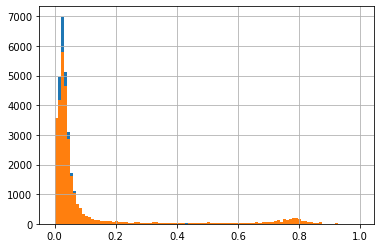

In [1]:
import gc
import re
import scipy
import numpy as np
import pandas as pd
from scipy import sparse
from pprint import pprint
from lightgbm import LGBMRegressor
from IPython.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 300


# # Training data
# ## Convert the label to SUM of all toxic labels (This might help with maintaining toxicity order of comments)
df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
df["severe_toxic"] = df.severe_toxic * 2
df["y"] = (
    df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(
        axis=1
    )
).astype(int)
df["y"] = df["y"] / df["y"].max()
df = df[["comment_text", "y"]].rename(columns={"comment_text": "text"})
df.sample(5)

df["y"].value_counts()

# ## Create 3 versions of the data
n_folds = 7
save_dir = "/kaggle/working"
ruddit_path = "../input/ruddit-jigsaw-dataset/Dataset"
# save_dir = "../save"


def save_raw_df(df):
    frac_1 = 0.3
    frac_1_factor = 1.2
    for fld in range(n_folds):
        print(f"Fold: {fld}")
        tmp1 = df[df.y > 0].sample(frac=frac_1, random_state=10 * (fld + 1))
        tmp2 = df[df.y == 0].sample(
            n=int(len(df[df.y > 0]) * frac_1 * frac_1_factor),
            random_state=10 * (fld + 1),
        )
        tmp_df = pd.concat([tmp1, tmp2], axis=0).sample(
            frac=1, random_state=10 * (fld + 1)
        )
        tmp_df.to_csv(f"{save_dir}/df_fld{fld}.csv", index=False)
        print(tmp_df.shape)
        print(tmp_df["y"].value_counts())


# # Create 3 versions of __clean__ data
import nltk
from nltk.corpus import stopwords

stop = stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

# def lemmatize_text(text): return [lemmatizer.lemmatize(w) for w in text]


def clean(data, col):
    data[col] = data[col].str.replace(r"what's", "what is ")
    data[col] = data[col].str.replace(r"\'ve", " have ")
    data[col] = data[col].str.replace(r"can't", "cannot ")
    data[col] = data[col].str.replace(r"n't", " not ")
    data[col] = data[col].str.replace(r"i'm", "i am ")
    data[col] = data[col].str.replace(r"\'re", " are ")
    data[col] = data[col].str.replace(r"\'d", " would ")
    data[col] = data[col].str.replace(r"\'ll", " will ")
    data[col] = data[col].str.replace(r"\'scuse", " excuse ")
    data[col] = data[col].str.replace(r"\'s", " ")
    data[col] = data[col].str.replace("\n", " \n ")
    data[col] = data[col].str.replace(r"([a-zA-Z]+)([/!?.])([a-zA-Z]+)", r"\1 \2 \3")
    data[col] = data[col].str.replace(r"([*!?\'])\1\1{2,}", r"\1\1\1")
    data[col] = data[col].str.replace(r"([*!?\']+)", r" \1 ")
    data[col] = data[col].str.replace(r"([a-zA-Z])\1{2,}\b", r"\1\1")
    data[col] = data[col].str.replace(r"([a-zA-Z])\1\1{2,}\B", r"\1\1\1")
    data[col] = data[col].str.replace(r"[ ]{2,}", " ").str.strip()
    data[col] = data[col].str.replace(r"[ ]{2,}", " ").str.strip()
    data[col] = data[col].apply(
        lambda x: " ".join([word for word in x.split() if word not in (stop)])
    )
    return data


def save_cleaned_df(df):
    df = clean(df, "text")
    n_folds = 7
    frac_1 = 0.3
    frac_1_factor = 1.2
    for fld in range(n_folds):
        tmp_df = pd.concat(
            [
                df[df.y > 0].sample(frac=frac_1, random_state=10 * (fld + 1)),
                df[df.y == 0].sample(
                    n=int(len(df[df.y > 0]) * frac_1 * frac_1_factor),
                    random_state=10 * (fld + 1),
                ),
            ],
            axis=0,
        ).sample(frac=1, random_state=10 * (fld + 1))
        tmp_df.to_csv(f"{save_dir}/df_clean_fld{fld}.csv", index=False)
        print(tmp_df.shape)
        print(tmp_df["y"].value_counts())


def save_ruddit_df():

    # ## Ruddit data
    df_ = pd.read_csv(f"{ruddit_path}/ruddit_with_text.csv")
    print(df_.shape)
    df_ = df_[["txt", "offensiveness_score"]].rename(
        columns={"txt": "text", "offensiveness_score": "y"}
    )
    df_["y"] = (df_["y"] - df_.y.min()) / (df_.y.max() - df_.y.min())
#     df_.y.hist()

    # # Create 3 versions of data
    n_folds = 7
    frac_1 = 0.7
    for fld in range(n_folds):
        print(f"Fold: {fld}")
        tmp_df = df_.sample(frac=frac_1, random_state=10 * (fld + 1))
        tmp_df.to_csv(f"{save_dir}/df2_fld{fld}.csv", index=False)
        print(tmp_df.shape)
        print(tmp_df["y"].value_counts())


save_cleaned_df(df)
save_raw_df(df)
save_ruddit_df()

# ## Load Validation and Test data
df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

# Create Sklearn Pipeline with
# TFIDF - Take 'char_wb' as analyzer to capture subwords well
# Ridge - Ridge is a simple regression algorithm that will reduce overfitting

# % of uppercase characters
class LengthUpperTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return sparse.csr_matrix(
            [[sum([1 for y in x if y.isupper()]) / len(x)] for x in X]
        )

    def get_feature_names(self):
        return ["lngth_uppercase"]


df_val["upper_1"] = np.array(
    LengthUpperTransformer().transform(df_val["less_toxic"]).todense()
).reshape(-1, 1)
df_val["upper_2"] = np.array(
    LengthUpperTransformer().transform(df_val["more_toxic"]).todense()
).reshape(-1, 1)
print(df_val["upper_1"].mean(), df_val["upper_1"].std())
print(df_val["upper_2"].mean(), df_val["upper_2"].std())
df_val["upper_1"].hist(bins=100)
df_val["upper_2"].hist(bins=100)


In [2]:
df_val['upper_1'].head(3)

0    0.026316
1    0.017167
2    0.041237
Name: upper_1, dtype: float64

In [3]:

# ## Train pipeline
#
# - Load folds data
# - train pipeline
# - Predict on validation data
# - Predict on test data

# ### Toxic data


def train_on_raw_df():
    val_preds_arr1 = np.zeros((df_val.shape[0], n_folds))
    val_preds_arr2 = np.zeros((df_val.shape[0], n_folds))
    test_preds_arr = np.zeros((df_sub.shape[0], n_folds))

    for fld in range(n_folds):
        print("\n\n")
        print(
            f" ****************************** FOLD: {fld} ******************************"
        )
        df = pd.read_csv(f"{save_dir}/df_fld{fld}.csv")
        print(df.shape)

        features = FeatureUnion(
            [
                (
                    "vect3",
                    TfidfVectorizer(
                        min_df=3, max_df=0.5, analyzer="char_wb", ngram_range=(3, 5)
                    ),
                ),
            ]
        )
        pipeline = Pipeline([("features", features), ("clf", Ridge()),])
        print("\nTrain:")
        pipeline.fit(df["text"], df["y"])
        print(
            "\nTotal number of features:", len(pipeline["features"].get_feature_names())
        )
        # feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), np.round(pipeline['clf'].coef_,2) )), key = lambda x:x[1], reverse=True)
        # pprint(feature_wts[:30])

        print("\npredict validation data ")
        val_preds_arr1[:, fld] = pipeline.predict(df_val["less_toxic"])
        val_preds_arr2[:, fld] = pipeline.predict(df_val["more_toxic"])

        print("\npredict test data ")
        test_preds_arr[:, fld] = pipeline.predict(df_sub["text"])
    return val_preds_arr1, val_preds_arr2, test_preds_arr


# # Toxic __clean__ data
def train_on_clean_data():

    val_preds_arr1c = np.zeros((df_val.shape[0], n_folds))
    val_preds_arr2c = np.zeros((df_val.shape[0], n_folds))
    test_preds_arrc = np.zeros((df_sub.shape[0], n_folds))

    for fld in range(n_folds):
        print("\n\n")
        print(
            f" ****************************** FOLD: {fld} ******************************"
        )
        df = pd.read_csv(f"{save_dir}/df_clean_fld{fld}.csv")
        print(df.shape)

        features = FeatureUnion(
            [
                (
                    "vect3",
                    TfidfVectorizer(
                        min_df=3, max_df=0.5, analyzer="char_wb", ngram_range=(3, 5)
                    ),
                ),
            ]
        )
        pipeline = Pipeline([("features", features), ("clf", Ridge()),])
        print("\nTrain:")
        pipeline.fit(df["text"], df["y"])
        print(
            "\nTotal number of features:", len(pipeline["features"].get_feature_names())
        )
        # feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), np.round(pipeline['clf'].coef_,2) )), key = lambda x:x[1], reverse=True)
        # pprint(feature_wts[:30])

        print("\npredict validation data ")
        val_preds_arr1c[:, fld] = pipeline.predict(df_val["less_toxic"])
        val_preds_arr2c[:, fld] = pipeline.predict(df_val["more_toxic"])

        print("\npredict test data ")
        test_preds_arrc[:, fld] = pipeline.predict(df_sub["text"])
    return val_preds_arr1c, val_preds_arr2c, test_preds_arrc


# ## Ruddit data pipeline


def train_on_ruddit_data():

    val_preds_arr1_ = np.zeros((df_val.shape[0], n_folds))
    val_preds_arr2_ = np.zeros((df_val.shape[0], n_folds))
    test_preds_arr_ = np.zeros((df_sub.shape[0], n_folds))

    for fld in range(n_folds):
        print("\n\n")
        print(
            f" ****************************** FOLD: {fld} ******************************"
        )
        df = pd.read_csv(f"{save_dir}/df2_fld{fld}.csv")
        print(df.shape)

        features = FeatureUnion(
            [
                (
                    "vect3",
                    TfidfVectorizer(
                        min_df=3, max_df=0.5, analyzer="char_wb", ngram_range=(3, 5)
                    ),
                ),
            ]
        )
        pipeline = Pipeline([("features", features), ("clf", Ridge()),])
        print("\nTrain:")
        pipeline.fit(df["text"], df["y"])

        print(
            "\nTotal number of features:", len(pipeline["features"].get_feature_names())
        )
        # feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), np.round(pipeline['clf'].coef_,2) )), key = lambda x:x[1], reverse=True)
        # pprint(feature_wts[:30])

        print("\npredict validation data ")
        val_preds_arr1_[:, fld] = pipeline.predict(df_val["less_toxic"])
        val_preds_arr2_[:, fld] = pipeline.predict(df_val["more_toxic"])

        print("\npredict test data ")
        test_preds_arr_[:, fld] = pipeline.predict(df_sub["text"])
    return val_preds_arr1_, val_preds_arr2_, test_preds_arr_


val_preds_arr1, val_preds_arr2, test_preds_arr = train_on_raw_df()
val_preds_arr1c, val_preds_arr2c, test_preds_arrc = train_on_clean_data()
val_preds_arr1_, val_preds_arr2_, test_preds_arr_ = train_on_ruddit_data()


print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f"Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}")




 ****************************** FOLD: 0 ******************************
(10709, 2)

Train:

Total number of features: 75032

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(10709, 2)

Train:

Total number of features: 74635

predict validation data 

predict test data 



 ****************************** FOLD: 2 ******************************
(10709, 2)

Train:

Total number of features: 74452

predict validation data 

predict test data 



 ****************************** FOLD: 3 ******************************
(10709, 2)

Train:

Total number of features: 75816

predict validation data 

predict test data 



 ****************************** FOLD: 4 ******************************
(10709, 2)

Train:

Total number of features: 74327

predict validation data 

predict test data 



 ****************************** FOLD: 5 ******************************
(10709, 2)

Train:

Total number of features: 75102

predict valid

In [4]:
print(" Toxic CLEAN data new ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f"Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}")

 Toxic CLEAN data new 
Validation Accuracy is 67.47


# Validate the pipeline

In [5]:
print(" Toxic data ")
p1 = val_preds_arr1.mean(axis=1)
p2 = val_preds_arr2.mean(axis=1)

print(f"Validation Accuracy is { np.round((p1 < p2).mean() * 100,2)}")

print(" Ruddit data ")
p3 = val_preds_arr1_.mean(axis=1)
p4 = val_preds_arr2_.mean(axis=1)

print(f"Validation Accuracy is { np.round((p3 < p4).mean() * 100,2)}")

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f"Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}")


def find_weights():
    wts_acc = []
    for i in range(30, 70, 1):
        for j in range(0, 20, 1):
            w1 = i / 100
            w2 = (100 - i - j) / 100
            w3 = 1 - w1 - w2
            p1_wt = w1 * p1 + w2 * p3 + w3 * p5
            p2_wt = w1 * p2 + w2 * p4 + w3 * p6
            wts_acc.append((w1, w2, w3, np.round((p1_wt < p2_wt).mean() * 100, 2)))
    sorted(wts_acc, key=lambda x: x[3], reverse=True)[:5]

    w1, w2, w3, _ = sorted(wts_acc, key=lambda x: x[2], reverse=True)[0]
    p1_wt = w1 * p1 + w2 * p3 + w3 * p5
    p2_wt = w1 * p2 + w2 * p4 + w3 * p6
    return w1, w2, w3, p1_wt, p2_wt


w1, w2, w3, p1_wt, p2_wt = find_weights()

# ## Analyze bad predictions
# ### Incorrect predictions with similar scores
# ### Incorrect predictions with different scores

df_val["p1"] = p1_wt
df_val["p2"] = p2_wt
df_val["diff"] = np.abs(p2_wt - p1_wt)
df_val["correct"] = (p1_wt < p2_wt).astype("int")


df_val[df_val.correct == 0].sort_values("diff", ascending=True).head(20)
#### Some of these just look incorrectly tagged
df_val[df_val.correct == 0].sort_values("diff", ascending=False).head(20)

# # Predict on test data
df_sub["score"] = (
    w1 * test_preds_arr.mean(axis=1)
    + w2 * test_preds_arr_.mean(axis=1)
    + w3 * test_preds_arrc.mean(axis=1)
)

# ## Correct the rank ordering
df_sub["score"].count() - df_sub["score"].nunique()
same_score = df_sub["score"].value_counts().reset_index()[:10]
same_score

df_sub[df_sub["score"].isin(same_score["index"].tolist())]
df_sub[["comment_id", "score"]].to_csv("submission.csv", index=False)


 Toxic data 
Validation Accuracy is 67.47
 Ruddit data 
Validation Accuracy is 62.57
 Toxic CLEAN data 
Validation Accuracy is 67.47


In [6]:

# ############## BERT

# # # Bert Ensemble
# import os
# import gc
# import cv2
# import copy
# import time
# import torch
# import random
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from transformers import AutoTokenizer, AutoModel

# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# CONFIG = dict(
#     seed=42,
#     model_name="../input/roberta-base",
#     test_batch_size=64,
#     max_length=128,
#     num_classes=1,
#     device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
# )

# CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG["model_name"])

# MODEL_PATHS = [
#     "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-0.bin",
#     "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-1.bin",
#     "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-2.bin",
#     "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-3.bin",
#     "../input/pytorch-w-b-jigsaw-starter/Loss-Fold-4.bin",
# ]


# def set_seed(seed=42):
#     """Sets the seed of the entire notebook so results are the same every time we run.
#     This is for REPRODUCIBILITY."""
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     os.environ["PYTHONHASHSEED"] = str(seed)


# class JigsawDataset(Dataset):
#     def __init__(self, df, tokenizer, max_length):
#         self.df = df
#         self.max_len = max_length
#         self.tokenizer = tokenizer
#         self.text = df["text"].values

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         text = self.text[index]
#         inputs = self.tokenizer.encode_plus(
#             text,
#             truncation=True,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding="max_length",
#         )

#         ids = inputs["input_ids"]
#         mask = inputs["attention_mask"]

#         return {
#             "ids": torch.tensor(ids, dtype=torch.long),
#             "mask": torch.tensor(mask, dtype=torch.long),
#         }


# class JigsawModel(nn.Module):
#     def __init__(self, model_name):
#         super(JigsawModel, self).__init__()
#         self.model = AutoModel.from_pretrained(model_name)
#         self.drop = nn.Dropout(p=0.2)
#         self.fc = nn.Linear(768, CONFIG["num_classes"])

#     def forward(self, ids, mask):
#         out = self.model(input_ids=ids, attention_mask=mask, output_hidden_states=False)
#         out = self.drop(out[1])
#         outputs = self.fc(out)
#         return outputs


# @torch.no_grad()
# def valid_fn(model, dataloader, device):
#     model.eval()

#     dataset_size = 0
#     running_loss = 0.0

#     PREDS = []

#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     for step, data in bar:
#         ids = data["ids"].to(device, dtype=torch.long)
#         mask = data["mask"].to(device, dtype=torch.long)

#         outputs = model(ids, mask)
#         PREDS.append(outputs.view(-1).cpu().detach().numpy())

#     PREDS = np.concatenate(PREDS)
#     gc.collect()

#     return PREDS


# def inference(model_paths, dataloader, device):
#     final_preds = []
#     for i, path in enumerate(model_paths):
#         model = JigsawModel(CONFIG["model_name"])
#         model.to(CONFIG["device"])
#         model.load_state_dict(torch.load(path))

#         print(f"Getting predictions for model {i+1}")
#         preds = valid_fn(model, dataloader, device)
#         final_preds.append(preds)

#     final_preds = np.array(final_preds)
#     final_preds = np.mean(final_preds, axis=0)
#     return final_preds


# set_seed(CONFIG["seed"])
# df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
# df.head()

# test_dataset = JigsawDataset(df, CONFIG["tokenizer"], max_length=CONFIG["max_length"])
# test_loader = DataLoader(
#     test_dataset,
#     batch_size=CONFIG["test_batch_size"],
#     num_workers=2,
#     shuffle=False,
#     pin_memory=True,
# )
# preds1 = inference(MODEL_PATHS, test_loader, CONFIG["device"])

# preds = (preds1 - preds1.min()) / (preds1.max() - preds1.min())
# df_sub["score"] = df_sub["score"] * 0.85 + preds * 0.15
# df_sub[["comment_id", "score"]].to_csv("submission.csv", index=False)